# Neural model for Deepmind TurnerLab (Pillar IV) 2AFC Task

**Data Source:** *16FlYMaze System, Turner Lab, HHMI Janelia Research Campus*

**Collected By:** *Kaitlyn Boone, Aparna Dev, PTR, HHMI Janelia Research Campus*

**Code Author:** *Rishika Mohanta*


In [1]:
# LIBRARY IMPORTS

# import libraries
import numpy as np                      # for numerical operations
import pandas as pd                     # for data manipulation
import matplotlib.pyplot as plt         # for plotting
import scipy.optimize as opt            # for optimization
from joblib import Parallel, delayed    # for parallelization
from tqdm.notebook import tqdm          # for progress bar
import pickle                           # for saving and loading
import os                               # for file operations
import gzip                             # for compressing files 
import torch                            # for neural networks
import torch.nn as nn                   # for neural networks
import torch.nn.functional as F         # for neural networks
from torch.utils.data import TensorDataset, DataLoader # for neural networks
import copy                             # for copying objects

# import statistics modules
from scipy.stats import wilcoxon       # for wilcoxon signed-rank test
from sklearn.cluster import AgglomerativeClustering # for clustering

# import sklearn modules
from sklearn.linear_model import LogisticRegression # for logistic regression

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
data_path = '../data/dmData_14-09-2023/' # path to data files
fit_path = '../processed_data/dmData_14-09-2023/' # path to fitted models
quality_control = 'full' # whether to perform quality control (valid options: minimal, full, none)
last_date = '2024-06-10 00:00:00' # last date of data collection
recalculate = False # whether to recalculate all data (True) or load from file (False)

In [3]:
# DATA LOADING

# load data
choice_data = np.loadtxt(data_path + 'choices.csv', delimiter=',')
reward_data = np.loadtxt(data_path + 'rewards.csv', delimiter=',')

# turn into integers
choice_data = choice_data.astype(int)
reward_data = reward_data.astype(int)

if choice_data.shape != reward_data.shape:
    raise ValueError('Sizes do not match.')

N = choice_data.shape[0]    # number of flies

print("Data loaded successfully with N = {} flies and {} maximum trials".format(N, choice_data.shape[1]))

# load metadata
metadata = pd.read_csv(data_path + 'metadata.csv')
metadata['Experiment Start Time'] = pd.to_datetime(metadata['Experiment Start Time'], format='%Y-%m-%d %H:%M:%S')
metadata['Starvation Time'] = pd.to_datetime(metadata['Starvation Time'], format='%Y-%m-%d %H:%M:%S')

# load quality control data
qc = np.loadtxt(data_path + 'quality_control.csv', delimiter=',').astype(bool)

Data loaded successfully with N = 446 flies and 1318 maximum trials


/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_74417/2453591249.py:8: RuntimeWarning: invalid value encountered in cast
  choice_data = choice_data.astype(int)
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_74417/2453591249.py:9: RuntimeWarning: invalid value encountered in cast
  reward_data = reward_data.astype(int)


In [4]:
# remove all control flies
choice_data = choice_data[metadata['Fly Experiment'] != 'control.csv']
reward_data = reward_data[metadata['Fly Experiment'] != 'control.csv']
qc = qc[metadata['Fly Experiment'] != 'control.csv']
metadata = metadata[metadata['Fly Experiment'] != 'control.csv']
choice_data = choice_data[metadata['Fly Experiment'] != 'control_reciprocal.csv']
reward_data = reward_data[metadata['Fly Experiment'] != 'control_reciprocal.csv']
qc = qc[metadata['Fly Experiment'] != 'control_reciprocal.csv']
metadata = metadata[metadata['Fly Experiment'] != 'control_reciprocal.csv']
metadata.reset_index(drop=True, inplace=True)

In [5]:
# QUALITY CONTROL

if quality_control == 'minimal':
    choice_data = choice_data[qc]
    reward_data = reward_data[qc]
    metadata = metadata[qc]
    metadata.reset_index(drop=True, inplace=True)
if quality_control == 'full':
    metadata = metadata[qc]
    metadata = metadata[metadata['Experiment Start Time'] < last_date].groupby('Fly Experiment').head(3)
    choice_data = choice_data[metadata.index]
    reward_data = reward_data[metadata.index]
    metadata.reset_index(drop=True, inplace=True)

print("{}/{} ({}) flies passed quality control".format(choice_data.shape[0], N, "{:0.2f}".format(choice_data.shape[0]/N*100)))

N = choice_data.shape[0]    # number of flies

360/446 (80.72) flies passed quality control


In [6]:
# Helper Functions for Dataset

def get_valid_data(x):
    # check if x in a numpy array
    if not isinstance(x, np.ndarray):
        x_ = np.array(x)
    else:
        x_ = x.copy()
    x_ = x_[~np.isnan(x_)]
    x_ = x_[~np.isinf(x_)]
    x_ = x_[x_>=0]
    return x_

def get_split_data(choices=choice_data, rewards=reward_data, K=2):
    """
    Get the split choice and reward data for a given number of folds.
    
    Parameters
    ----------
    choices : numpy.ndarray
        The choice data.
    rewards : numpy.ndarray
        The reward data.
    K : int
        The number of folds.
    """
    vals = []
    for i in range(K):
        cs_temp = choices[i::K]
        cs = []
        for c in cs_temp:
            cs += [get_valid_data(c)]
        rs_temp = rewards[i::K]
        rs = []
        for r in rs_temp:
            rs += [get_valid_data(r)]
        vals.append((cs, rs))
    return vals

def log_likelihood(predictions,observations):
    """
    Calculate the bernoulli log likelihood of the observation given the prediction.

    Parameters
    ----------
    predictions : numpy.ndarray
        The predictions.
    observations : numpy.ndarray
        The observations.
    """
    lls = []
    assert len(predictions) == len(observations), "The number of predictions and observations must be the same."
    for i in range(len(predictions)):
        lls += [np.sum(np.log(predictions[i])*observations[i]+np.log(1-predictions[i])*(1-observations[i]))]
    return lls

def normalized_log_likelihood(predictions,observations):
    """
    Calculate the normalized bernoulli log likelihood of the observation given the prediction.

    Parameters
    ----------
    predictions : numpy.ndarray
        The predictions.
    observations : numpy.ndarray
        The observations.
    """
    norm_lls = []
    assert len(predictions) == len(observations), "The number of predictions and observations must be the same."
    for i in range(len(predictions)):
        norm_lls += [np.exp(np.mean(np.log(predictions[i])*observations[i]+np.log(1-predictions[i])*(1-observations[i])))]
    return norm_lls

# Storing all data directories
all_models = {}

# create fit directory if it doesn't exist
if not os.path.exists(fit_path):
    os.makedirs(fit_path)
    os.makedirs(fit_path + 'fit_results/')


In [7]:
# HELPERS FUNCTIONS FOR FITTING REGRESSION MODELS

def get_design_matrix(choice, reward, history_size, mode='full'):
    """
    Returns X and y created by taking history size steps back in time to predict the current choice.

    Parameters
    ----------
    choice : array_like
        The choices made by the subject.
    reward : array_like
        The rewards received by the subject.
    history_size : int
        The number of steps back in time to take.
    mode : str, optional
        The mode to use. Can be 'full' or 'cr_only'. Default is 'full'.
    """
    if isinstance(choice, list):
        choice = np.array(choice)
    if isinstance(reward, list):
        reward = np.array(reward)
    # create copy of choice and reward
    c = choice.copy()
    r = reward.copy()
    # create dummy variables for choices of 0 and 1
    c = (np.int32(c)-0.5)*2

    if mode == 'full':
        X = np.zeros((len(c), history_size * 3))
    elif mode == 'cr_only':
        X = np.zeros((len(c), history_size * 2))
    y = np.zeros(len(c))

    # Pad choices with 0.5, rewards with 0, interactions with 0
    c = np.concatenate((np.zeros(history_size), c))
    r = np.concatenate((np.zeros(history_size), r))
    if mode == 'full':
        interaction1 = c * r
        interaction2 = c * (1 - r)

    # Fill design matrix
    for n,i in enumerate(range(history_size, len(c))):
        if mode == 'full':
            X[n, 0:history_size] = c[i - history_size:i]
            X[n, history_size:2 * history_size] = r[i - history_size:i]
            X[n, 2 * history_size:3 * history_size] = interaction1[i - history_size:i]
            # X[n, 3 * history_size:4 * history_size] = interaction2[i - history_size:i]
        elif mode == 'cr_only':
            X[n, 0:history_size] = c[i - history_size:i]
            X[n, history_size:2 * history_size] = r[i - history_size:i]
        y[n] = c[i]
    return X, y

In [8]:
# FUNCTIONS TO FIT WSLG BASELINE MODEL

def fit_logreg(choices,rewards,history_size=10,mode='full'):
    """
    Fits a logistic regression model to the data.
    """
    N = len(choices)
    Xs = []
    ys = []
    for i in range(N):
        X,y = get_design_matrix(choices[i], rewards[i], history_size=history_size, mode=mode)
        Xs.append(X)
        ys.append(y)
    X = np.vstack(Xs)
    y = np.hstack(ys)
    # Define and fit the model
    clf = LogisticRegression(penalty='l2',C=1e6,solver='lbfgs')
    clf.fit(X,y)
    # Return the model
    return clf

def predict_prob_logreg(choices,rewards,model,history_size=10,mode='full'):
    """
    Predict the probability of choosing odor 2 for each trial.
    """
    # get length of data
    N = len(choices)
    probs = []
    for i in range(N):
        X,_ = get_design_matrix(choices[i], rewards[i], history_size=history_size, mode=mode)
        probs.append(model.predict_proba(X)[:,1])
    return probs

In [9]:
def get_probabilities(fly_no,return_trial_count=False):
    exp_name = metadata['Fly Experiment'][fly_no]
    exp_data = pd.read_csv(data_path+'experiments/'+exp_name)
    trial_count = sum(choice_data[fly_no,:] >= 0)
    # get probability of choosing reward for each odor
    p_1 = exp_data['P(R|O1)'].values[:trial_count]
    p_2 = exp_data['P(R|O2)'].values[:trial_count]
    if return_trial_count:
        return p_1, p_2, trial_count
    else:
        return p_1, p_2

## A Neuronal Model of the Fly's Choice Behavior

We know that the mushroom body is a key structure in the fly brain that is involved in learning and memory. We also know that the mushroom body has a large number of neurons that are involved in the fly's choice behavior. 

Particularly, the Kenyon Cells (KCs) are the neurons that receive the input from the olfactory system and are involved in the fly's choice behavior. These KCs then project to the Mushroom Body Output Neurons (MBONs) which are the neurons that drive the fly's behavioral response i.e. whether the animals continue to stay in the walk upwind or turn away from the odor. However, the strength of the synaptic connections between the KCs and MBONs are not fixed, and are modulated by the dopaminergic neurons. More specifically, reward activated dopaminergic neurons depress the synaptic connections from KCs to aversive MBONs and therefore drive the fly to stay in the odor. On the other hand, punishment activated dopaminergic neurons depress the synaptic connections from KCs to appetitive MBONs and therefore drive the fly to turn away from the odor.

We can model this system to see if we can predict the fly's choice behavior. Since we have a reward only experiment, we can model the reward activated dopaminergic neurons and the aversive MBONs. We can then use the KCs as the input to the model and the MBONs as the output of the model. We can then use the MBONs activity under the two odor conditions to predict the fly's choice behavior.

Lets assume the following:
1. The KC activation by the two odors is non-overlapping i.e. each odor activates a different set of KCs, and therefore plasticity in the KC-MBON synapses is independent of each other. Thus we can consider only two populations of KCs, one for each odor.


In [10]:
# define a class for modelling the mushroom body
class MushroomBody:
    # initialize the mushroom body
    def __init__(self,mu_inh=0.1,hr=0.9,lr=0.5,up_dr=5.0,fb_syn=0.1,fb_trans=0.1,fb_up=1.0):
        self.hr = hr # homeostatic plasticity rate
        self.lr = lr # learning rate
        self.w_KC_pMBON = np.array([1.0, 1.0]) # weights from KC to MBON (appetitive)
        self.w_KC_nMBON = np.array([1.0, 1.0]) # weights from KC to MBON (aversive)
        # mutual inhibition between MBONs (Felsenberg et al., 2018)
        self.w_nMBON_pMBON = -1.0*mu_inh # weight from aversive MBON to appetitive MBON 
        self.w_pMBON_nMBON = -1.0*mu_inh # weight from appetitive MBON to aversive MBON
        # MBON to DAN feedback
        self.w_pMBON_pDANs = -1.0*fb_syn # weight from appetitive MBON to reward DANs (inhibitory to subtract reward expectation)
        self.w_nMBON_nDANs = 0#-1.0*fb_syn # weight from aversive MBON to punishment DANs (inhibitory to subtract punishment expectation)
        self.w_pMBON_nDANs = 0#1.0*fb_trans # weight from appetitive MBON to punishment DANs (excitatory to subtract punishment expectation)
        self.w_nMBON_pDANs = 1.0*fb_trans # weight from aversive MBON to reward DANs (excitatory to subtract reward expectation)
        # Upwind Neuron inputs
        self.w_pMBON_U = 1.0*up_dr # weight from appetitive MBON to upwind neuron (appetitive means upwind will be activated)
        self.w_nMBON_U = -1.0*up_dr # weight from aversive MBON to upwind neuron (aversive means upwind will be inhibited)
        # Upwind Neuron feedback to Dopamine Neurons
        self.w_U_pDANs = 1.0*fb_up # weight from upwind neuron to reward DANs
        self.w_U_nDANs = 0#-1.0*fb_up # weight from upwind neuron to punishment DANs
        # Activation function 
        self.activation = lambda x: x if x>0 else 0 # ReLU activation function

        # to store current values
        self.MBON_actvity = np.array([0.0, 0.0])
        self.DAN_activity = np.array([0.0, 0.0])
        self.U_activity = 0.0

    # get the upwind drive for each odor without causing plasticity
    def upwind_drive(self, time_since_last_trial=1,verbose=False):
        """
        A function to calculate the upwind drive for each odor without causing plasticity
        
        Parameters:
        -----------
        time_since_last_trial: float
            time since last trial in seconds (for now we set it to 1 arbitrary trial length)
        verbose: bool
            whether to print the values at each step
        """
        if verbose:
            print("\nCalculating upwind drive for Odor 1 and Odor 2 after {:.0f} seconds".format(time_since_last_trial))

        drives = []
        for KC_activation in [np.array([1,0]),np.array([0,1])]:
            
            if verbose:
                print("KC activations:", KC_activation)
            
            # Step 1: calculate the KC MBON weights after homeostatic plasticity (exponential decay back to 1)
            w_KC_pMBON_ = self.w_KC_pMBON + (1-self.w_KC_pMBON)*(1-np.exp(-self.hr*time_since_last_trial))
            w_KC_nMBON_ = self.w_KC_nMBON + (1-self.w_KC_nMBON)*(1-np.exp(-self.hr*time_since_last_trial))
            
            if verbose:
                print("KC->MBON weights before homeostasis: Appetitive", self.w_KC_pMBON, "Aversive", self.w_KC_nMBON)
                print("KC->MBON weights after plasticity: Appetitive", w_KC_pMBON_, "Aversive", w_KC_nMBON_)
            
            
            # Step 2: calculate the MBON activations
            MBON_activation = np.array(
                [
                    self.activation(np.dot(w_KC_pMBON_, KC_activation)),
                    self.activation(np.dot(w_KC_nMBON_, KC_activation))
                ]
            )
            
            if verbose:
                print("MBON activations: Appetitive", MBON_activation[0], "Aversive", MBON_activation[1])
            
            
            # Step 3: account for mutual inhibition between MBONs
            MBON_updated = np.array(
                [
                    self.activation(MBON_activation[0] + self.w_nMBON_pMBON*MBON_activation[1]),
                    self.activation(MBON_activation[1] + self.w_pMBON_nMBON*MBON_activation[0])
                ]
            )
            
            if verbose:
                print("MBON activations after mutual inhibition: Appetitive", MBON_updated[0], "Aversive", MBON_updated[1])
            
            
            # Step 4: calculate the upwind drive
            upwind_drive = self.activation(np.dot(MBON_updated, np.array([self.w_pMBON_U, self.w_nMBON_U])))
            
            if verbose:
                print("Upwind drive:", upwind_drive)
            
            drives.append(upwind_drive)
    
        if verbose:
            print()
            
        return drives



    def trial_plasticity(self, odor, reward, time_since_last_trial=1,stim="sensory",strength=1,verbose=False):
        """
        A function to calculate the plasticity for a single trial

        Parameters:
        -----------
        odor: int
            odor number (0 or 1)
        reward: int
            reward number (-1 or 1 or 0)
        time_since_last_trial: float
            time since last trial in seconds (for now we set it to 1 arbitrary trial length)
        verbose: bool
            whether to print the values at each step
        """

        if verbose:
            print("\nCalculating plasticity for Odor {} and {} after {:.0f} seconds".format(odor+1, "Reward" if reward==1 else "Punishment", time_since_last_trial))

        # Step 0: calculate the KC activations
        if odor == 0:
            KC_activation = np.array([1,0])
        elif odor == 1:
            KC_activation = np.array([0,1])
        
        if verbose:
            print("KC activations:", KC_activation)

        # Step 0.5: calculate the DAN activations
        force_nDAN = 0
        force_pDAN = 0

        if reward == 1:
            if stim == "sensory":
                pDAN_activation = 1 * strength
                nDAN_activation = 0 * strength
                upwind_drive = 0 * strength
            elif stim == "upwind":
                pDAN_activation = 0 * strength
                nDAN_activation = 0 * strength
                upwind_drive = 1 * strength
            elif stim == "dan":
                pDAN_activation = 0 * strength
                nDAN_activation = 0 * strength
                upwind_drive = 0 * strength
                force_pDAN = 1 * strength
                force_nDAN = 0 * strength
        elif reward == -1:
            if stim == "sensory":
                pDAN_activation = 0 * strength
                nDAN_activation = 1 * strength
                upwind_drive = 0
            elif stim == "upwind":
                pDAN_activation = 0 * strength
                nDAN_activation = 0 * strength
                upwind_drive = 0 * strength
            elif stim == "dan":
                pDAN_activation = 0 * strength
                nDAN_activation = 0 * strength
                upwind_drive = 0 * strength
                force_pDAN = 0 * strength
                force_nDAN = 1 * strength
        else:
            pDAN_activation = 0
            nDAN_activation = 0
            upwind_drive = 0

        
        if verbose:
            print("DAN activations: Reward", pDAN_activation, "Punishment", nDAN_activation)

        # Step 1: calculate the KC MBON weights after homeostatic plasticity (exponential decay back to 1)
        if verbose:
            print("KC->MBON weights before homeostasis: Appetitive", self.w_KC_pMBON, "Aversive", self.w_KC_nMBON)

        self.w_KC_pMBON = self.w_KC_pMBON + (1-self.w_KC_pMBON)*(1-np.exp(-self.hr*time_since_last_trial))
        self.w_KC_nMBON = self.w_KC_nMBON + (1-self.w_KC_nMBON)*(1-np.exp(-self.hr*time_since_last_trial))

        if verbose:
            print("KC->MBON weights after homeostasis: Appetitive", self.w_KC_pMBON, "Aversive", self.w_KC_nMBON)


        # Step 2: calculate the MBON activations
        MBON_activation = np.array(
            [
                self.activation(np.dot(self.w_KC_pMBON, KC_activation)),
                self.activation(np.dot(self.w_KC_nMBON, KC_activation))
            ]
        )

        if verbose:
            print("MBON activations: Appetitive", MBON_activation[0], "Aversive", MBON_activation[1])

        # Step 3: account for mutual inhibition between MBONs
        MBON_updated = np.array(
            [
                self.activation(MBON_activation[0] + self.w_nMBON_pMBON*MBON_activation[1]),
                self.activation(MBON_activation[1] + self.w_pMBON_nMBON*MBON_activation[0])
            ]
        )

        if verbose:
            print("MBON activations after mutual inhibition: Appetitive", MBON_updated[0], "Aversive", MBON_updated[1])

        self.MBON_actvity = MBON_updated

        # Step 4: calculate the upwind drive
        upwind_drive = self.activation(upwind_drive+np.dot(MBON_updated, np.array([self.w_pMBON_U, self.w_nMBON_U])))

        if verbose:
            print("Upwind drive:", upwind_drive)

        self.U_activity = upwind_drive

        # Step 5: calculate the DAN activations
        # pDAN_activation = self.activation(pDAN_activation + self.w_U_pDANs*upwind_drive + self.w_pMBON_pDANs*MBON_updated[0] + self.w_nMBON_pDANs*MBON_updated[1])
        # nDAN_activation = self.activation(nDAN_activation + self.w_U_nDANs*upwind_drive + self.w_pMBON_nDANs*MBON_updated[0] + self.w_nMBON_nDANs*MBON_updated[1])

        # force DAN activations if needed
        if force_pDAN != 0:
            if verbose:
                print("Forcing DAN activation for reward")
            pDAN_activation = self.activation(force_pDAN)
        else:
            pDAN_activation = self.activation(pDAN_activation + self.w_U_pDANs*upwind_drive + self.w_pMBON_pDANs*MBON_updated[0] + self.w_nMBON_pDANs*MBON_updated[1] - self.w_nMBON_pDANs)
        if force_nDAN != 0:
            if verbose:
                print("Forcing DAN activation for punishment")
            nDAN_activation = self.activation(force_nDAN)
        else:
            nDAN_activation = self.activation(nDAN_activation + self.w_U_nDANs*upwind_drive + self.w_pMBON_nDANs*MBON_updated[0] + self.w_nMBON_nDANs*MBON_updated[1] - self.w_pMBON_nDANs)

        if verbose:
            print("DAN activations: Reward", pDAN_activation, "Punishment", nDAN_activation)

        self.DAN_activity = np.array([pDAN_activation, nDAN_activation])

        # Step 6: calculate the plasticity
        if verbose:
            print("KC->MBON weights before plasticity: Appetitive", self.w_KC_pMBON, "Aversive", self.w_KC_nMBON)

        self.w_KC_pMBON = self.w_KC_pMBON - self.lr*nDAN_activation*KC_activation*self.w_KC_pMBON
        self.w_KC_nMBON = self.w_KC_nMBON - self.lr*pDAN_activation*KC_activation*self.w_KC_nMBON

        if verbose:
            print("KC->MBON weights after plasticity: Appetitive", self.w_KC_pMBON, "Aversive", self.w_KC_nMBON)
            print()

    def get_weights(self):
        return self.w_KC_pMBON, self.w_KC_nMBON      

    def get_MBON_activity(self):
        return self.MBON_actvity

    def get_DAN_activity(self):
        return self.DAN_activity

    def get_U_activity(self):
        return self.U_activity  

## Testing the Model

In [11]:
params = {
    'hr': 0.1, # homeostatic plasticity rate
    'lr': 0.1, # learning rate
    'up_dr': 6, # upwind drive
    'fb_trans': 0.5, # MBON to DAN feedback positive->negative and negative->positive
    'fb_syn': 0.0, # MBON to DAN feedback negative->negative and positive->positive
    'fb_up': 0.5, # upwind drive to DAN feedback
    'mu_inh': 0.0, # mutual inhibition between MBONs
}

In [12]:
MB = MushroomBody(**params)
print("Initial KC to MBON weights: p ", MB.get_weights()[0], " and n ", MB.get_weights()[1])
# get the upwind drive for each odor without causing plasticity
drives = MB.upwind_drive(0)
print("Upwind drive for odor 1: ", drives[0], " and odor 2: ", drives[1])
# run a trial with odor 1 and reward
MB.trial_plasticity(0,1,0,verbose=True)
print("Updated KC to MBON weights: p ", MB.get_weights()[0], " and n ", MB.get_weights()[1])
# get the upwind drive for each odor without causing plasticity
drives = MB.upwind_drive(0)
print("Upwind drive for odor 1: ", drives[0], " and odor 2: ", drives[1])

Initial KC to MBON weights: p  [1. 1.]  and n  [1. 1.]
Upwind drive for odor 1:  0  and odor 2:  0

Calculating plasticity for Odor 1 and Reward after 0 seconds
KC activations: [1 0]
DAN activations: Reward 1 Punishment 0
KC->MBON weights before homeostasis: Appetitive [1. 1.] Aversive [1. 1.]
KC->MBON weights after homeostasis: Appetitive [1. 1.] Aversive [1. 1.]
MBON activations: Appetitive 1.0 Aversive 1.0
MBON activations after mutual inhibition: Appetitive 1.0 Aversive 1.0
Upwind drive: 0
DAN activations: Reward 1.0 Punishment 0
KC->MBON weights before plasticity: Appetitive [1. 1.] Aversive [1. 1.]
KC->MBON weights after plasticity: Appetitive [1. 1.] Aversive [0.9 1. ]

Updated KC to MBON weights: p  [1. 1.]  and n  [0.9 1. ]
Upwind drive for odor 1:  0.5999999999999996  and odor 2:  0


In [53]:
def plot_dynamics(choices,rewards,upwind_drives,weights,MBON_activities,DAN_activities):
    col=(((rewards+1)*(1-2*choices))+2)/4
    if len(choices.shape) == 1:
        # add a dimension at the front
        choices = choices[np.newaxis,:]
        rewards = rewards[np.newaxis,:]
        upwind_drives = upwind_drives[np.newaxis,:,:]
        weights = weights[np.newaxis,:,:]
        MBON_activities = MBON_activities[np.newaxis,:,:]
        DAN_activities = DAN_activities[np.newaxis,:,:]

    t = choices.shape[1]
    
    # plot the upwind drives
    plt.figure(figsize=(5,1))
    plt.plot(upwind_drives.mean(axis=0)[:,1],label='Preference')
    for i in range(len(choices)):
        plt.scatter(np.arange(t),choices[i],c=col[i],s=1,cmap='RdBu',alpha=0.5)
    plt.xlabel('Trial Number')
    plt.ylabel('Upwind Drive')
    plt.xlim(0,t)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.box(False)
    plt.show()

    # plot the weights
    plt.figure(figsize=(5,1))
    plt.plot(weights.mean(axis=0)[:,0,0],label='KC 1 -> Appetitive')
    plt.plot(weights.mean(axis=0)[:,0,1],label='KC 2 -> Appetitive')
    plt.plot(weights.mean(axis=0)[:,1,0],label='KC 1 -> Aversive')
    plt.plot(weights.mean(axis=0)[:,1,1],label='KC 2 -> Aversive')
    plt.xlabel('Trial Number')
    plt.ylabel('Weight')
    plt.xlim(0,t)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.box(False)
    plt.show()

    # plot the MBON activities
    plt.figure(figsize=(5,1))
    plt.plot(MBON_activities.mean(axis=0)[:,0],label='Appetitive')
    plt.plot(MBON_activities.mean(axis=0)[:,1],label='Aversive')
    plt.xlabel('Trial Number')
    plt.ylabel('MBON Activity')
    plt.xlim(0,t)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.box(False)
    plt.show()

    # plot the DAN activities
    plt.figure(figsize=(5,1))
    plt.plot(DAN_activities.mean(axis=0)[:,0],label='Reward')
    plt.plot(DAN_activities.mean(axis=0)[:,1],label='Punishment')
    plt.xlabel('Trial Number')
    plt.ylabel('DAN Activity')
    plt.xlim(0,t)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.box(False)
    plt.show()

In [56]:

# random_choices = np.concatenate([np.random.randint(0,2,size=50),np.random.randint(0,2,size=50)])
# random_rewards = np.concatenate([np.random.choice([0,1],p=[0.5,0.5],size=50),np.zeros(50)])
random_rewards = np.zeros((120,2))
random_rewards[20:70,0] = 0.8
random_rewards[20:70,1] = 0.2
random_rewards[70:120,1] = 0.8
random_rewards[70:120,0] = 0.2

n_repeats = 90

## Simple Alternation Experiment with Normal Model

  0%|          | 0/90 [00:00<?, ?it/s]

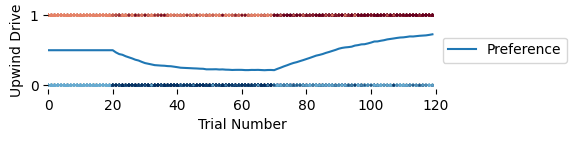

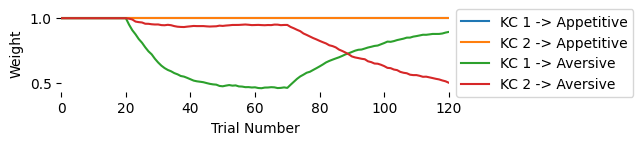

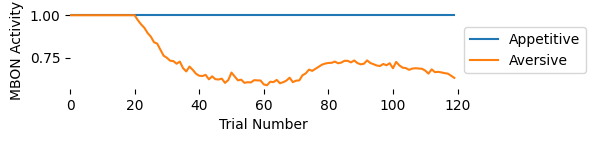

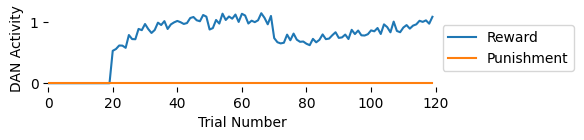

In [57]:
params = {
    'hr': 0.1, # homeostatic plasticity rate
    'lr': 0.1, # learning rate
    'up_dr': 3, # upwind drive
    'fb_trans': 0.5, # MBON to DAN feedback positive->negative and negative->positive
    'fb_syn': 0.0, # MBON to DAN feedback negative->negative and positive->positive
    'fb_up': 0.5, # upwind drive to DAN feedback
    'mu_inh': 0.0, # mutual inhibition between MBONs
}

all_choices = []
all_rewards = []
all_upwind_drives = []
all_weights = []
all_MBON_activities = []
all_DAN_activities = []

for _ in tqdm(range(n_repeats)):

    MB = MushroomBody(
        **params
    )
    upwind_drives = []
    MBON_activities = []
    DAN_activities = []
    rewards = []
    choices = []

    weights = [MB.get_weights()]
    for i in range(len(random_rewards)):
        # get upwind drive
        upwind_drive = MB.upwind_drive()
        upwind_drive = np.exp(upwind_drive)/np.sum(np.exp(upwind_drive))
        upwind_drives.append(upwind_drive)
        # sample choice
        choice = np.random.choice([0,1],p=upwind_drive)
        choices.append(choice)
        # get reward
        reward_prob = random_rewards[i,choices[i]]
        reward = np.random.choice([0,1],p=[1-reward_prob,reward_prob])
        rewards.append(reward)
        # plasticity
        MB.trial_plasticity(choices[i],rewards[i],stim="sensory",strength=1)
        # store updated weights
        weights.append(MB.get_weights())
        MBON_activities.append(MB.get_MBON_activity())
        DAN_activities.append(MB.get_DAN_activity())

    choices = np.array(choices)
    rewards = np.array(rewards)
    upwind_drives = np.array(upwind_drives)
    weights = np.array(weights)
    MBON_activities = np.array(MBON_activities)
    DAN_activities = np.array(DAN_activities)

    # store data
    all_choices.append(choices)
    all_rewards.append(rewards)
    all_upwind_drives.append(upwind_drives)
    all_weights.append(weights)
    all_MBON_activities.append(MBON_activities)
    all_DAN_activities.append(DAN_activities)

# convert to numpy arrays
all_choices = np.array(all_choices)
all_rewards = np.array(all_rewards)
all_upwind_drives = np.array(all_upwind_drives)
all_weights = np.array(all_weights)
all_MBON_activities = np.array(all_MBON_activities)
all_DAN_activities = np.array(all_DAN_activities)
    
plot_dynamics(all_choices,all_rewards,all_upwind_drives,all_weights,all_MBON_activities,all_DAN_activities)

  0%|          | 0/90 [00:00<?, ?it/s]

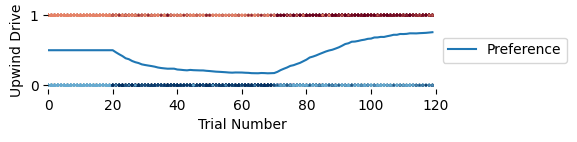

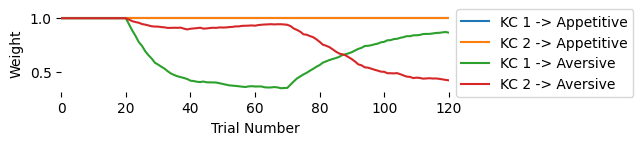

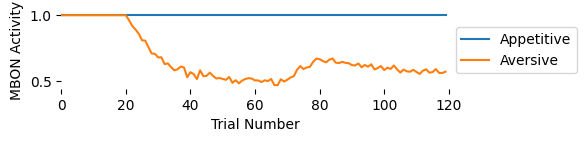

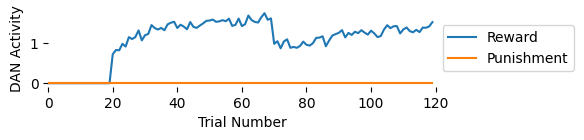

In [58]:
params = {
    'hr': 0.1, # homeostatic plasticity rate
    'lr': 0.1, # learning rate
    'up_dr': 3, # upwind drive
    'fb_trans': 0.5, # MBON to DAN feedback positive->negative and negative->positive
    'fb_syn': 0.0, # MBON to DAN feedback negative->negative and positive->positive
    'fb_up': 0.5, # upwind drive to DAN feedback
    'mu_inh': 0.0, # mutual inhibition between MBONs
}

all_choices = []
all_rewards = []
all_upwind_drives = []
all_weights = []
all_MBON_activities = []
all_DAN_activities = []

for _ in tqdm(range(n_repeats)):

    MB = MushroomBody(
        **params
    )
    upwind_drives = []
    MBON_activities = []
    DAN_activities = []
    rewards = []
    choices = []

    weights = [MB.get_weights()]
    for i in range(len(random_rewards)):
        # get upwind drive
        upwind_drive = MB.upwind_drive()
        upwind_drive = np.exp(upwind_drive)/np.sum(np.exp(upwind_drive))
        upwind_drives.append(upwind_drive)
        # sample choice
        choice = np.random.choice([0,1],p=upwind_drive)
        choices.append(choice)
        # get reward
        reward_prob = random_rewards[i,choices[i]]
        reward = np.random.choice([0,1],p=[1-reward_prob,reward_prob])
        rewards.append(reward)
        # plasticity
        MB.trial_plasticity(choices[i],rewards[i],stim="upwind",strength=3)
        # store updated weights
        weights.append(MB.get_weights())
        MBON_activities.append(MB.get_MBON_activity())
        DAN_activities.append(MB.get_DAN_activity())

    choices = np.array(choices)
    rewards = np.array(rewards)
    upwind_drives = np.array(upwind_drives)
    weights = np.array(weights)
    MBON_activities = np.array(MBON_activities)
    DAN_activities = np.array(DAN_activities)

    # store data
    all_choices.append(choices)
    all_rewards.append(rewards)
    all_upwind_drives.append(upwind_drives)
    all_weights.append(weights)
    all_MBON_activities.append(MBON_activities)
    all_DAN_activities.append(DAN_activities)

# convert to numpy arrays
all_choices = np.array(all_choices)
all_rewards = np.array(all_rewards)
all_upwind_drives = np.array(all_upwind_drives)
all_weights = np.array(all_weights)
all_MBON_activities = np.array(all_MBON_activities)
all_DAN_activities = np.array(all_DAN_activities)
    
plot_dynamics(all_choices,all_rewards,all_upwind_drives,all_weights,all_MBON_activities,all_DAN_activities)

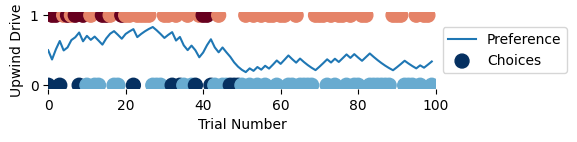

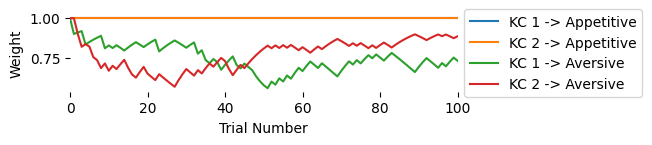

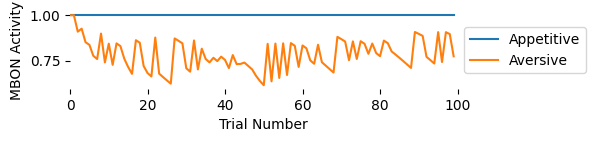

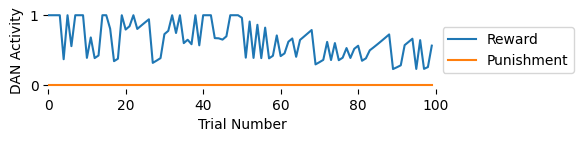

In [21]:
params = {
    'hr': 0.1, # homeostatic plasticity rate
    'lr': 0.1, # learning rate
    'up_dr': 6, # upwind drive
    'fb_trans': 0.5, # MBON to DAN feedback positive->negative and negative->positive
    'fb_syn': 0.0, # MBON to DAN feedback negative->negative and positive->positive
    'fb_up': 0.5, # upwind drive to DAN feedback
    'mu_inh': 0.0, # mutual inhibition between MBONs
}

MB = MushroomBody(
    **params
)
upwind_drives = []
MBON_activities = []
DAN_activities = []

weights = [MB.get_weights()]
for i in range(len(random_choices)):
    upwind_drive = MB.upwind_drive()
    # apply softmax to upwind drives
    upwind_drive = np.exp(upwind_drive)/np.sum(np.exp(upwind_drive))
    upwind_drives.append(upwind_drive)
    MB.trial_plasticity(random_choices[i],random_rewards[i],stim="dan",strength=1)
    weights.append(MB.get_weights())
    MBON_activities.append(MB.get_MBON_activity())
    DAN_activities.append(MB.get_DAN_activity())

upwind_drives = np.array(upwind_drives)
weights = np.array(weights)
MBON_activities = np.array(MBON_activities)
DAN_activities = np.array(DAN_activities)

plot_dynamics(random_choices,random_rewards,upwind_drives,weights,MBON_activities,DAN_activities)

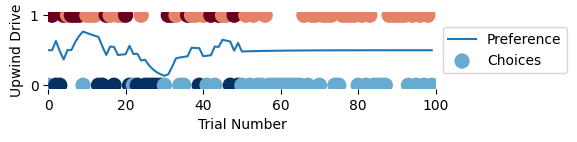

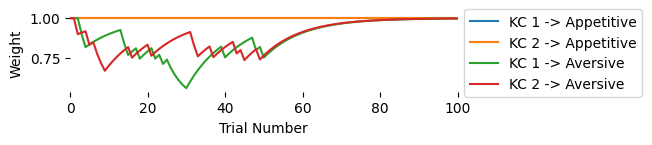

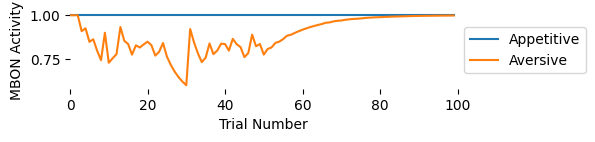

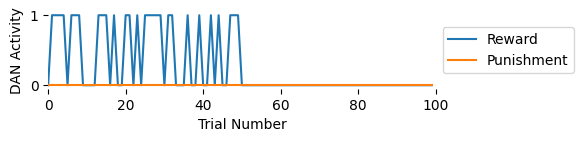

In [618]:
params = {
    'hr': 0.1, # homeostatic plasticity rate
    'lr': 0.1, # learning rate
    'up_dr': 6, # upwind drive
    'fb_trans': 0.0, # MBON to DAN feedback positive->negative and negative->positive
    'fb_syn': 0.0, # MBON to DAN feedback negative->negative and positive->positive
    'fb_up': 0.0, # upwind drive to DAN feedback
    'mu_inh': 0.0, # mutual inhibition between MBONs
}

MB = MushroomBody(
    **params
)
upwind_drives = []
MBON_activities = []
DAN_activities = []

weights = [MB.get_weights()]
for i in range(len(random_choices)):
    upwind_drive = MB.upwind_drive()
    # apply softmax to upwind drives
    upwind_drive = np.exp(upwind_drive)/np.sum(np.exp(upwind_drive))
    upwind_drives.append(upwind_drive)
    MB.trial_plasticity(random_choices[i],random_rewards[i],stim="sensory",strength=1)
    weights.append(MB.get_weights())
    MBON_activities.append(MB.get_MBON_activity())
    DAN_activities.append(MB.get_DAN_activity())

upwind_drives = np.array(upwind_drives)
weights = np.array(weights)
MBON_activities = np.array(MBON_activities)
DAN_activities = np.array(DAN_activities)

plot_dynamics(random_choices,random_rewards,upwind_drives,weights,MBON_activities,DAN_activities)

In [598]:
# generate data with this model
def simulate_experiment(params,stim='sugar',strength=1):
    n_data = N # number of experiments

    # loop over experiments
    generated_choices = []
    generated_rewards = []

    for i in tqdm(range(n_data)):
        # choose the number of trials from data
        p_1,p_2,n_trials = get_probabilities(i,return_trial_count=True)
        reward_schedule = np.zeros((n_trials,2))
        for i in range(n_trials):
            reward_schedule[i,0] = np.random.choice([0,1],p=[1-p_1[i],p_1[i]])
            reward_schedule[i,1] = np.random.choice([0,1],p=[1-p_2[i],p_2[i]])
        # perform simulation
        MB = MushroomBody(
            **params
            )
        upwind_drive = MB.upwind_drive()
        # apply softmax to upwind drives
        upwind_drive = np.exp(upwind_drive)/np.sum(np.exp(upwind_drive))
        # randomly choose the odor
        choice = np.random.choice([0,1],p=upwind_drive)
        choices=[choice]
        rewards = []
        for j in range(n_trials):
            rewards.append(reward_schedule[j,choices[j]])
            MB.trial_plasticity(choices[j],reward_schedule[j,choices[j]],stim=stim,strength=strength)
            upwind_drive = MB.upwind_drive(1)
            # apply softmax to upwind drivess
            upwind_drive = np.exp(upwind_drive)/np.sum(np.exp(upwind_drive))
            # randomly choose the odor
            choice = np.random.choice([0,1],p=upwind_drive)
            choices.append(choice)

        rewards = np.array(rewards)
        choices = np.array(choices[:-1])

        generated_choices.append(choices)
        generated_rewards.append(rewards)

    generated_choices = np.array(generated_choices,dtype=object)
    generated_rewards = np.array(generated_rewards,dtype=object)

    return generated_choices, generated_rewards



  0%|          | 0/360 [00:00<?, ?it/s]

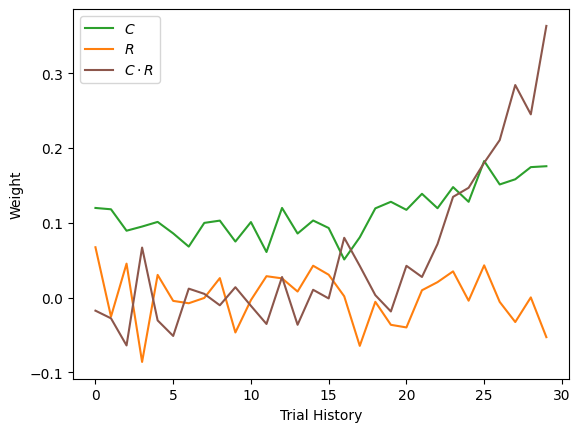

In [621]:
# generate data with this model
# params = {
#     'hr': 0.01,
#     'lr': 0.075,
#     'up_dr': 4,
#     'fb_syn': 1.0,
#     'fb_up': 0,
# }

params = {
    'hr': 0.1, # homeostatic plasticity rate
    'lr': 0.1, # learning rate
    'up_dr': 6, # upwind drive
    'fb_trans': 0.5, # MBON to DAN feedback positive->negative and negative->positive
    'fb_syn': 0.0, # MBON to DAN feedback negative->negative and positive->positive
    'fb_up': 0.5, # upwind drive to DAN feedback
    'mu_inh': 0.0, # mutual inhibition between MBONs
}

generated_choices, generated_rewards = simulate_experiment(params,stim='sensory',strength=1)

# fit logistic to generated data
HISTORY_SIZE = 30

model = fit_logreg(generated_choices, generated_rewards, HISTORY_SIZE,'full')
names = [r'$C$', r'$R$', r'$C \cdot R$', r'$C \cdot (1-R)$']
colors = ['tab:green', 'tab:orange', 'tab:brown', 'tab:purple']
for i in range(3):
    plt.plot(np.array_split(model.coef_[0], model.coef_[0].shape[0]//HISTORY_SIZE)[i], label=names[i], color=colors[i])

plt.xlabel('Trial History')
plt.ylabel('Weight')
plt.legend()
plt.show()

  0%|          | 0/360 [00:00<?, ?it/s]

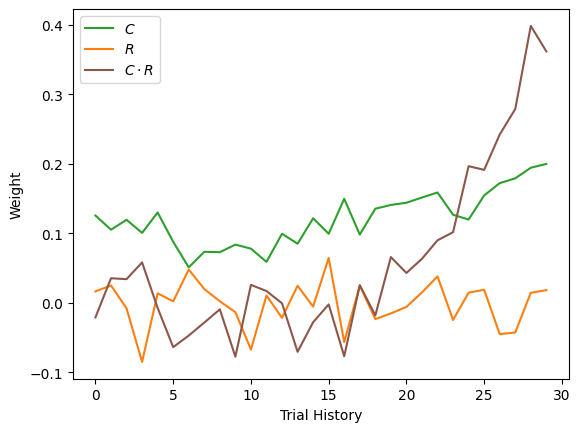

In [623]:
# params = {
#     'hr': 0.2,
#     'lr': 0.075,
#     'up_dr': 4,
#     'fb_syn': 0.0,
#     'fb_up': 0,
# }

params = {
    'hr': 0.1, # homeostatic plasticity rate
    'lr': 0.1, # learning rate
    'up_dr': 6, # upwind drive
    'fb_trans': 0.0, # MBON to DAN feedback positive->negative and negative->positive
    'fb_syn': 0.0, # MBON to DAN feedback negative->negative and positive->positive
    'fb_up': 0.5, # upwind drive to DAN feedback
    'mu_inh': 0.0, # mutual inhibition between MBONs
}


generated_choices, generated_rewards = simulate_experiment(params,stim='sensory',strength=1)

# fit logistic to generated data
HISTORY_SIZE = 30

model = fit_logreg(generated_choices, generated_rewards, HISTORY_SIZE,'full')
names = [r'$C$', r'$R$', r'$C \cdot R$', r'$C \cdot (1-R)$']
colors = ['tab:green', 'tab:orange', 'tab:brown', 'tab:purple']
for i in range(3):
    plt.plot(np.array_split(model.coef_[0], model.coef_[0].shape[0]//HISTORY_SIZE)[i], label=names[i], color=colors[i])

plt.xlabel('Trial History')
plt.ylabel('Weight')
plt.legend()
plt.show()

  0%|          | 0/360 [00:00<?, ?it/s]

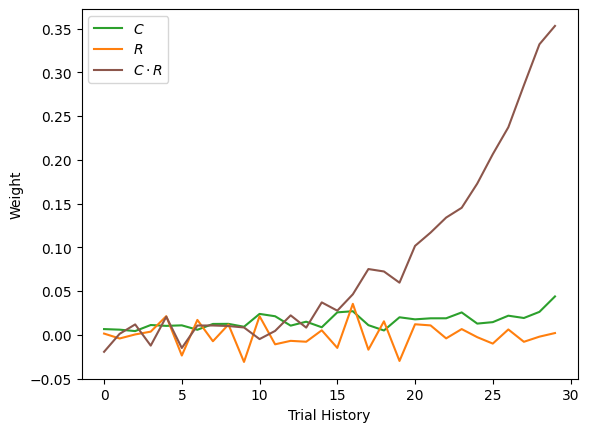

In [624]:
params = {
    'hr': 0.1, # homeostatic plasticity rate
    'lr': 0.1, # learning rate
    'up_dr': 6, # upwind drive
    'fb_trans': 0.5, # MBON to DAN feedback positive->negative and negative->positive
    'fb_syn': 0.0, # MBON to DAN feedback negative->negative and positive->positive
    'fb_up': 0.0, # upwind drive to DAN feedback
    'mu_inh': 0.0, # mutual inhibition between MBONs
}


generated_choices, generated_rewards = simulate_experiment(params,stim='sensory',strength=1)

# fit logistic to generated data
HISTORY_SIZE = 30

model = fit_logreg(generated_choices, generated_rewards, HISTORY_SIZE,'full')
names = [r'$C$', r'$R$', r'$C \cdot R$', r'$C \cdot (1-R)$']
colors = ['tab:green', 'tab:orange', 'tab:brown', 'tab:purple']
for i in range(3):
    plt.plot(np.array_split(model.coef_[0], model.coef_[0].shape[0]//HISTORY_SIZE)[i], label=names[i], color=colors[i])

plt.xlabel('Trial History')
plt.ylabel('Weight')
plt.legend()
plt.show()

  0%|          | 0/360 [00:00<?, ?it/s]

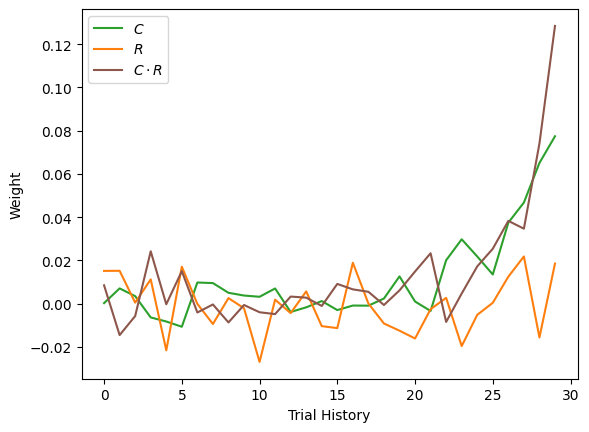

In [426]:
# params = {
#     'hr': 0.2,
#     'lr': 0.075,
#     'up_dr': 4,
#     'fb_syn': 0.0,
#     'fb_up': 0,
# }

params = {
    'hr': 0.1, # homeostatic plasticity rate
    'lr': 0.5, # learning rate
    'up_dr': 1, # upwind drive
    'fb_trans': 0.5, # MBON to DAN feedback positive->negative and negative->positive
    'fb_syn': 0.0,  # MBON to DAN feedback negative->negative and positive->positive
    'fb_up': 0.5, # upwind drive to DAN feedback
    'mu_inh': 0.0, # mutual inhibition between MBONs
}

generated_choices, generated_rewards = simulate_experiment(params,stim='sensory',strength=1)

# fit logistic to generated data
HISTORY_SIZE = 30

model = fit_logreg(generated_choices, generated_rewards, HISTORY_SIZE,'full')
names = [r'$C$', r'$R$', r'$C \cdot R$', r'$C \cdot (1-R)$']
colors = ['tab:green', 'tab:orange', 'tab:brown', 'tab:purple']
for i in range(3):
    plt.plot(np.array_split(model.coef_[0], model.coef_[0].shape[0]//HISTORY_SIZE)[i], label=names[i], color=colors[i])

plt.xlabel('Trial History')
plt.ylabel('Weight')
plt.legend()
plt.show()

  0%|          | 0/360 [00:00<?, ?it/s]

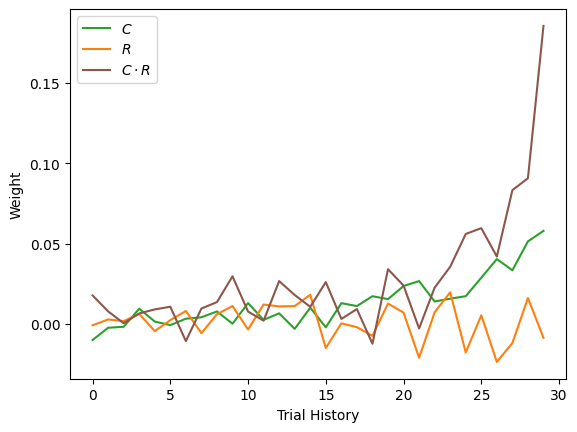

In [427]:
params = {
    'hr': 0.1, # homeostatic plasticity rate
    'lr': 0.5, # learning rate
    'up_dr': 1, # upwind drive
    'fb_trans': 0.0, # MBON to DAN feedback positive->negative and negative->positive
    'fb_syn': 0.0,  # MBON to DAN feedback negative->negative and positive->positive
    'fb_up': 0.5, # upwind drive to DAN feedback
    'mu_inh': 0.0, # mutual inhibition between MBONs
}

generated_choices, generated_rewards = simulate_experiment({**params,**ignored_params},stim='dan',strength=4)

# fit logistic to generated data
HISTORY_SIZE = 30

model = fit_logreg(generated_choices, generated_rewards, HISTORY_SIZE,'full')
names = [r'$C$', r'$R$', r'$C \cdot R$', r'$C \cdot (1-R)$']
colors = ['tab:green', 'tab:orange', 'tab:brown', 'tab:purple']
for i in range(3):
    plt.plot(np.array_split(model.coef_[0], model.coef_[0].shape[0]//HISTORY_SIZE)[i], label=names[i], color=colors[i])

plt.xlabel('Trial History')
plt.ylabel('Weight')
plt.legend()
plt.show()

In [100]:
def fit_cognitive_model(choices, rewards):
    def loglik(params):
        # params are:
        # 0: q_init_0 (initial value of odor 1)
        # 1: q_init_1 (initial value of odor 2)
        # 2: alpha_l (learning rate)
        # 3: alpha_f (forgetting rate)
        # 4: kappa (omission reward)
        # 5: delta (expectation sensitivity)
        # 5: beta (temperature)
        q_init_0,q_init_1,alpha_l, alpha_f, kappa, delta, beta = params
        sumloglik = 0
        for i in range(len(choices)):
            # initialize variables
            Q = np.array([q_init_0,q_init_1])
            Qs = [Q.copy()]
            choice_probs = []
            # get the reward schedule and choice schedule
            reward_schedule = rewards[i]
            choice_schedule = choices[i]
            # loop over trials
            for j in range(len(choice_schedule)):
                # get the choice and reward
                choice = choice_schedule[j]
                reward = reward_schedule[j]
                # calculate the probability of choosing odor 2
                p = np.clip(Q/beta,-100,100)
                p = np.exp(p)/np.sum(np.exp(p))
                choice_probs.append(p[1])
                # update the Q value
                if reward != 0:
                    Q[choice] = Q[choice] + alpha_l*(reward-delta*Q[choice])
                else:
                    Q[choice] = Q[choice] + alpha_l*(kappa-delta*Q[choice])
                Q[1-choice] = Q[1-choice] - alpha_f*(Q[1-choice])
                Qs.append(Q.copy())
            
            choice_probs = np.array(choice_probs)
            # calculate the log likelihood
            sumloglik += np.sum(np.log(choice_probs)*choice_schedule + np.log(1-choice_probs)*(1-choice_schedule))
            # plot the Q values to check
            # plt.plot(np.array(Qs)[:,0],label='Odor 1')
            # plt.plot(np.array(Qs)[:,1],label='Odor 2')
            # plt.show()
        return -sumloglik
    
    # fit the model using scipy
    from scipy.optimize import minimize

    # set the bounds
    bounds = [(0,1),(0,1),(0,1),(0,1),(-1,1),(0,1),(0.01,100)]
    # randomly initialize the parameters within the bounds
    init_param=[]
    for b in bounds:
        init_param.append(np.random.uniform(b[0],b[1]))
    # callback function to print the current log likelihood and parameters
    def callback(xk):
        print(loglik(xk),xk)

    # run the optimization
    res = minimize(loglik, init_param, bounds=bounds, method='Nelder-Mead', callback=callback)
    print(res)


# run the model
fit_cognitive_model(generated_choices, generated_rewards)

113183.68954024713 [ 0.14164369  0.20638737  0.54166657  0.61691997 -0.46112371  0.79809731
  4.56864176]
113183.68954024713 [ 0.14164369  0.20638737  0.54166657  0.61691997 -0.46112371  0.79809731
  4.56864176]
113011.10495901457 [ 0.14413008  0.21001027  0.55117491  0.62774931 -0.41439931  0.77383661
  4.79655586]
113011.10495901457 [ 0.14413008  0.21001027  0.55117491  0.62774931 -0.41439931  0.77383661
  4.79655586]
113011.10495901457 [ 0.14413008  0.21001027  0.55117491  0.62774931 -0.41439931  0.77383661
  4.79655586]
113011.10495901457 [ 0.14413008  0.21001027  0.55117491  0.62774931 -0.41439931  0.77383661
  4.79655586]
112677.49856726488 [ 0.13840497  0.21347952  0.59367517  0.62725229 -0.43490538  0.75852942
  4.22699497]
112677.49856726488 [ 0.13840497  0.21347952  0.59367517  0.62725229 -0.43490538  0.75852942
  4.22699497]
112677.49856726488 [ 0.13840497  0.21347952  0.59367517  0.62725229 -0.43490538  0.75852942
  4.22699497]
112357.15687807082 [ 0.15097567  0.21447598  0

/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_60154/2351463879.py:40: RuntimeWarning:

divide by zero encountered in log

/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_60154/2351463879.py:40: RuntimeWarning:

invalid value encountered in multiply



102213.76799099732 [ 0.16275138  0.27688448  0.82964858  0.70613947 -0.2084108   0.64169094
  0.93579465]
102213.76799099732 [ 0.16275138  0.27688448  0.82964858  0.70613947 -0.2084108   0.64169094
  0.93579465]
102213.76799099732 [ 0.16275138  0.27688448  0.82964858  0.70613947 -0.2084108   0.64169094
  0.93579465]
102213.76799099732 [ 0.16275138  0.27688448  0.82964858  0.70613947 -0.2084108   0.64169094
  0.93579465]
102213.76799099732 [ 0.16275138  0.27688448  0.82964858  0.70613947 -0.2084108   0.64169094
  0.93579465]
101447.94958375629 [ 0.16377815  0.28408093  0.82333114  0.72790236 -0.18369942  0.60474694
  1.08555215]
101447.94958375629 [ 0.16377815  0.28408093  0.82333114  0.72790236 -0.18369942  0.60474694
  1.08555215]
101447.94958375629 [ 0.16377815  0.28408093  0.82333114  0.72790236 -0.18369942  0.60474694
  1.08555215]
101447.94958375629 [ 0.16377815  0.28408093  0.82333114  0.72790236 -0.18369942  0.60474694
  1.08555215]
101447.94958375629 [ 0.16377815  0.28408093  0

In [279]:
# fit MB model to generated data to recover the weights (test)
def fit_MB(params,choices,rewards):
    # returns the log likelihood of the data given the parameters
    hr,lr,up_dr,fb_syn,fb_up= params
    # initialize the mushroom body
    sum_log_lik = 0
    for i in range(len(choices)):
        MB = MushroomBody(
            hr=hr,
            lr=lr,
            up_dr=up_dr,
            fb_syn=fb_syn,
            fb_up=fb_up,
            **ignored_params
        )
        upwind_drives = []
        for j in range(len(choices[i])):
            upwind_drive = MB.upwind_drive(1)
            # apply softmax to upwind drives
            upwind_drive = np.exp(upwind_drive)/np.sum(np.exp(upwind_drive))
            # add to the list
            upwind_drives.append(upwind_drive)
            # randomly choose the odor
            MB.trial_plasticity(choices[i][j],rewards[i][j],1)
        upwind_drives = np.array(upwind_drives)
        # calculate the log likelihood (bernoulli)
        log_lik = np.sum(np.log(upwind_drives[:,1])*choices[i] + np.log(upwind_drives[:,0])*(1-choices[i]))
        sum_log_lik += log_lik
    return sum_log_lik

# minimize the function
from scipy.optimize import minimize

# define the objective function
def objective(params):
    return -fit_MB(params,generated_choices,generated_rewards)

# define a callback function to print the progress at each iteration along with the current parameters
def callback(params):
    print('Current log likelihood: {:.3f}'.format(objective(params)))
    print("{:0.2f} {:0.2f} {:0.2f} {:0.2f} {:0.2f}".format(*params))


# define the starting point
params = np.array([0.2,0.075,4,0.1,1])+np.random.normal(0,0.2,size=5)

# constraints (all parameters must be positive and less than 1 except for the upwind drive which must be positive)
bnds = ((0.01, 1), (0.01, 1), (0.01, 10), (0.01, 1), (0.01, 1))

# perform the optimization
result = minimize(objective, params, bounds=bnds, method='Nelder-Mead', callback=callback)

# summarize the result
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
print('Total Iterations: %d' % result['nit'])
print('Best Solution: %s' % result['x'])
print('Best Objective: %s' % result['fun'])

/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_31511/1694029277.py:51: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective, params, bounds=bnds, method='Nelder-Mead', callback=callback)


Current log likelihood: -17770.136
0.40 0.20 3.71 0.01 1.00
Current log likelihood: -17770.136
0.40 0.20 3.71 0.01 1.00
Current log likelihood: -17770.136
0.40 0.20 3.71 0.01 1.00
Current log likelihood: -17696.489
0.42 0.20 3.64 0.01 1.00
Current log likelihood: -17696.489
0.42 0.20 3.64 0.01 1.00
Current log likelihood: -17696.489
0.42 0.20 3.64 0.01 1.00
Current log likelihood: -17696.489
0.42 0.20 3.64 0.01 1.00
Current log likelihood: -17696.489
0.42 0.20 3.64 0.01 1.00
Current log likelihood: -17696.489
0.42 0.20 3.64 0.01 1.00
Current log likelihood: -17690.925
0.41 0.19 3.65 0.01 1.00
Current log likelihood: -17690.925
0.41 0.19 3.65 0.01 1.00
Current log likelihood: -17690.925
0.41 0.19 3.65 0.01 1.00
Current log likelihood: -17690.925
0.41 0.19 3.65 0.01 1.00
Current log likelihood: -17675.726
0.40 0.20 3.53 0.01 1.00
Current log likelihood: -17663.078
0.39 0.20 3.40 0.01 1.00
Current log likelihood: -17663.078
0.39 0.20 3.40 0.01 1.00
Current log likelihood: -17663.078
0.39 

KeyboardInterrupt: 

In [280]:
# true parameters
true_params = [0.2,0.075,4,0.1,1]
# value of the objective function at the true parameters
true_obj = -objective(true_params)
print("True Objective: ", true_obj)

True Objective:  -17431.315851000236


In [306]:
# train the model on the actual data
def fit_MB(params,choices,rewards):
    # returns the log likelihood of the data given the parameters
    hr,lr,up_dr,fb_syn,fb_up= params
    # initialize the mushroom body
    sum_log_lik = 0
    for i in range(len(choices)):
        MB = MushroomBody(
            hr=hr,
            lr=lr,
            up_dr=up_dr,
            fb_syn=fb_syn,
            fb_up=fb_up,
            **ignored_params
        )
        upwind_drives = []
        for j in range(len(choices[i])):
            upwind_drive = MB.upwind_drive(1)
            # apply softmax to upwind drives
            upwind_drive = np.exp(upwind_drive)/np.sum(np.exp(upwind_drive))
            # add to the list
            upwind_drives.append(upwind_drive)
            # randomly choose the odor
            MB.trial_plasticity(choices[i][j],rewards[i][j],1)
        upwind_drives = np.array(upwind_drives)
        # calculate the log likelihood (bernoulli)
        log_lik = np.sum(np.log(upwind_drives[:,1])*choices[i] + np.log(upwind_drives[:,0])*(1-choices[i]))
        sum_log_lik += log_lik
    return sum_log_lik

cs = []
for i in range(len(choice_data)):
    cs.append(get_valid_data(choice_data[i]))
rs = []
for i in range(len(reward_data)):
    rs.append(get_valid_data(reward_data[i]))
cs = np.array(cs,dtype=object)
rs = np.array(rs,dtype=object)

# define the objective function
def objective(params):
    return -fit_MB(params,cs,rs)

# define a callback function to print the progress at each iteration along with the current parameters
def callback(params):
    print('Current log likelihood: {:.3f}'.format(objective(params)))
    print("{:0.2f} {:0.2f} {:0.2f} {:0.2f} {:0.2f}".format(*params))


# define the starting point
params = np.array([0.2,0.075,4,0.1,1])+np.random.normal(0,0.2,size=5)

# constraints
bnds = ((0.01, 1), (0.01, 1), (0.01, 10), (0.01, 10), (0.01, 10))

# perform the optimization
result = minimize(objective, params, bounds=bnds, method='Nelder-Mead', callback=callback)

# summarize the result
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
print('Total Iterations: %d' % result['nit'])
print('Best Solution: %s' % result['x'])
print('Best Objective: %s' % result['fun'])

/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_31511/987101827.py:57: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective, params, bounds=bnds, method='Nelder-Mead', callback=callback)


Current log likelihood: 102990.645
0.01 0.12 3.56 0.39 0.95
Current log likelihood: 102990.645
0.01 0.12 3.56 0.39 0.95
Current log likelihood: 102990.645
0.01 0.12 3.56 0.39 0.95
Current log likelihood: 102990.645
0.01 0.12 3.56 0.39 0.95
Current log likelihood: 102262.240
0.01 0.12 3.30 0.37 0.95
Current log likelihood: 102262.240
0.01 0.12 3.30 0.37 0.95
Current log likelihood: 102262.240
0.01 0.12 3.30 0.37 0.95


KeyboardInterrupt: 

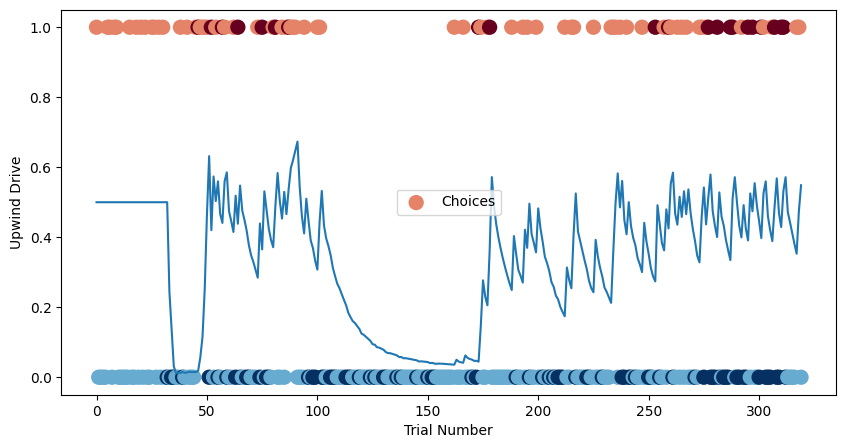

In [291]:
def pred_MB(params,choices,rewards):
    # returns the log likelihood of the data given the parameters
    hr,lr,up_dr,fb_syn,fb_up= params
    # initialize the mushroom body
    preds = []
    for i in range(len(choices)):
        MB = MushroomBody(
            hr=hr,
            lr=lr,
            up_dr=up_dr,
            fb_syn=fb_syn,
            fb_up=fb_up,
            **ignored_params
        )
        upwind_drives = []
        for j in range(len(choices[i])):
            upwind_drive = MB.upwind_drive(1)
            # apply softmax to upwind drives
            upwind_drive = np.exp(upwind_drive)/np.sum(np.exp(upwind_drive))
            # add to the list
            upwind_drives.append(upwind_drive)
            # randomly choose the odor
            MB.trial_plasticity(choices[i][j],rewards[i][j],1)
        upwind_drives = np.array(upwind_drives)
        preds.append(upwind_drives)
    return np.array(preds,dtype=object)
    
preds = pred_MB([0.04,0.26,3.74,0.06,0.79],cs,rs)
i = 0
col = (((rs[i]+1)*(1-2*cs[i]))+2)/4
plt.figure(figsize=(10,5))
plt.plot(preds[i][:,1])
plt.scatter(np.arange(len(cs[i])),cs[i],c=col,s=100,label='Choices',cmap='RdBu')
plt.xlabel('Trial Number')
plt.ylabel('Upwind Drive')
plt.legend()
plt.show()

### Alternative Model

#### Policy Gradient Methods

Policy gradient methods are a class of reinforcement learning methods that directly learn the policy function, i.e. the function that maps states to actions. The policy function is parameterized by a set of parameters $\theta$. The policy function is updated using the policy gradient theorem, which states that the gradient of the expected reward w.r.t. the policy parameters is equal to the expected reward times the gradient of the log of the policy function w.r.t. the policy parameters. 

The policy gradient methods are present in pygorl.cogpolicy.

For the policy gradient methods, since we are in a 1-state problem, each trial is the equivalent of a single session. So, $G_t = R_t$ for all $t$. We utilize the logistic (sigmoid) function as the policy function.

$$
\begin{gather}
\pi_t(a) = \frac{1}{1 + e^{-\theta_t}} \\
\end{gather}
$$

where $\theta_t$ is the policy parameter at trial $t$. The policy parameter is updated using the following update rule:

##### Vanilla Policy Gradient

$$
\begin{gather}
\text{Initialize } \theta_0 = \theta_{0,0} \\
\text{For each trial } t \text{, } \text{observe } a_t \text{ and } R_t \text{, and update } \theta_t \text{ as follows:} \\
\theta_{t+1} = \theta_t + \alpha \cdot R_t \cdot \Delta \pi_t(a_t) \\
\text{where } \Delta \pi_t \text{ is the gradient of the policy function w.r.t. } \theta_t \text{, evaluated at } a_t
\end{gather}
$$

where $\Delta \pi_t$ is the gradient of the policy function w.r.t. $\theta_t$, evaluated at $a_t$, and $\alpha$ is the learning rate for the policy parameters.

##### Actor-Critic

$$
\begin{gather}
\text{Initialize } \theta_0 = \theta_{0,0} \text{ and } Q_0(a) = q_{a,0} \text{ for all } a \in \mathcal{A} \\
\text{For each trial } t \text{, } \text{observe } a_t \text{ and } R_t \text{, and update } \theta_t \text{ and } Q_t \text{ as follows:} \\
\theta_{t+1} = \theta_t + \alpha_{policy} \cdot Q_t \cdot \Delta \pi_t(a_t) \\
Q_{t+1}(a_t) = Q_t(a_t) + \alpha_{learn} \cdot (R_t + (1-R_t)\cdot \kappa - Q_t(a_t)) \\
Q_{t+1}(a) = Q_t(a) - \alpha_{forget} \cdot Q_t(a) \text{, for all } a \neq a_t \\
\end{gather}
$$

where $\Delta \pi_t$ is the gradient of the policy function w.r.t. $\theta_t$, evaluated at $a_t$, and $\alpha_{policy}$ is the learning rate for the policy parameters, and $\alpha_{learn}$ and $\alpha_{forget}$ are the learning and forgetting rates for the Q-Values. $\kappa$ is the perceived reward for performing the action itself irrespective of the outcome.

### Advantage Actor-Critic

$$
\begin{gather}
\text{Initialize } \theta_0 = \theta_{0,0} \text{ and } V_0 = v \\
\text{For each trial } t \text{, } \text{observe } a_t \text{ and } R_t \text{, and update } \theta_t \text{ and } V_t \text{ as follows:} \\
\theta_{t+1} = \theta_t + \alpha_{policy} \cdot \Delta \pi_t(a_t) \cdot (R_t - V_t) \\
V_{t+1} = V_t + \alpha_{value} \cdot (R_t - V_t) \\
\end{gather}
$$

where $\Delta \pi_t$ is the gradient of the policy function w.r.t. $\theta_t$, evaluated at $a_t$, and $\alpha_{policy}$ is the learning rate for the policy parameters, and $\alpha_{value}$ is the learning rate for the value function. $v$ is the initial value for the value function.


In [ ]:
p_models = [
    {
        'name': 'Vanilla Policy Gradient',
        'class': VLPolicyGradient,
        'addl': {},
        'dir': fit_path+'VLP_2cv_de_20230714.pkl'
    },
    {
        'name': 'Actor-Critic Policy Gradient with Q-Learning Critic',
        'class': ACLPolicyGradient,
        'addl': {
            'q_type': 'q'
        },
        'dir': fit_path+'ACLP_Q_2cv_de_20230714.pkl'
    },
    {
        'name': 'Actor-Critic Policy Gradient with Q-Learning and Forgetting Critic',
        'class': ACLPolicyGradient,
        'addl': {
            'q_type': 'fq'
        },
        'dir': fit_path+'ACLP_FQ_2cv_de_20230714.pkl'
    },
    {
        'name': 'Actor-Critic Policy Gradient with Q-Learning, Forgetting and Omission Sensitivity Critic',
        'class': ACLPolicyGradient,
        'addl': {
            'q_type': 'osfq'
        },
        'dir': fit_path+'ACLP_OSFQ_2cv_de_20230714.pkl'
    },
    {
        'name': 'Advantage Actor-Critic Policy Gradient',
        'class': AdvLPolicyGradient,
        'addl': {},
        'dir': fit_path+'AdvLP_2cv_de_20230714.pkl'
    },
]

In [ ]:
split_data = get_split_data()

for model_no in range(len(p_models)):

    models = []
    train_probs = []
    test_probs = []
    train_log_liks = []
    test_log_liks = []
    train_norm_log_liks = []
    test_norm_log_liks = []
    train_pols = []
    test_pols = []

    model = p_models[model_no]['class'](**p_models[model_no]['addl'])
    params = pickle.load(open(p_models[model_no]['dir'], 'rb'))
    model_name = p_models[model_no]['name']
    print("Loaded results from disk.")

    # For train data
    for i, (choices, rewards) in enumerate(split_data):
        pols = []
        probs = []
        # Calculate Q values and probabilities for each trial
        for j in range(len(choices)):
            pol = model.policy_gradient_learning(choices[j], rewards[j], params[i].x)
            pols.append(pol[:-1,:])
            p = model.prob_choice(choices[j], rewards[j], params[i].x)
            probs.append(p[:-1,1])
        models.append(model)
        # Calculate log likelihoods
        train_log_liks.append(log_likelihood(probs,choices))
        # Calculate normalized log likelihoods
        train_norm_log_liks.append(normalized_log_likelihood(probs,choices))

    # For test data
    for i, (choices, rewards) in enumerate(split_data):
        pols = []
        probs = []
        # Calculate Q values and probabilities for each trial
        for j in range(len(choices)):
            pol = model.policy_gradient_learning(choices[j], rewards[j], params[1-i].x)
            pols.append(pol[:-1,:])
            p = model.prob_choice(choices[j], rewards[j], params[1-i].x)
            probs.append(p[:-1,1])
        models.append(model)
        # Calculate log likelihoods
        test_log_liks.append(log_likelihood(probs,choices))
        # Calculate normalized log likelihoods
        test_norm_log_liks.append(normalized_log_likelihood(probs,choices))

    train_log_liks = np.concatenate(train_log_liks)
    test_log_liks = np.concatenate(test_log_liks)
    train_norm_log_liks = np.concatenate(train_norm_log_liks)
    test_norm_log_liks = np.concatenate(test_norm_log_liks)

    # Save to disk using compressed pickle format
    if not os.path.isdir(fit_path+'fit_results/'):
        os.mkdir(fit_path+'fit_results/')

    all_data = {
        'params': params,
        'train_log_liks': train_log_liks,
        'test_log_liks': test_log_liks,
        'train_norm_log_liks': train_norm_log_liks,
        'test_norm_log_liks': test_norm_log_liks,
        'train_probs': train_probs,
        'test_probs': test_probs,
        'train_qs': train_qs,
        'test_qs': test_qs,
    }

    # Dump to disk
    ShortName = str(p_models[model_no]["class"]).split(".")[-1][:-2]
    with gzip.open(fit_path+f'fit_results/{ShortName}_fit_results.pkl.gz', 'wb') as f:
        pickle.dump(all_data, f)



    print("ESTIMATED {} PARAMETERS".format(model_name.upper()))
    print("======================="+ "="*(len(model_name)-2))
    print()

    param_names = model.param_props()['names']
    for i, param in enumerate(param_names):
        print("{}: {:.3f}, {:.3f}".format(param, params[0].x[i], params[1].x[i]))
        
    # Summarize the results (mean and 95% CI)
    print("\nMODEL FIT")
    print("=========")
    print()
    print('Train log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
        train_log_liks.mean(), *np.percentile(train_log_liks, [2.5, 97.5])))
    print('Test log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
        test_log_liks.mean(), *np.percentile(test_log_liks, [2.5, 97.5])))
    print('Train normalized log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
        train_norm_log_liks.mean(), *np.percentile(train_norm_log_liks, [2.5, 97.5])))
    print('Test normalized log likelihood: {:.3f} [{:.3f}, {:.3f}]'.format(
        test_norm_log_liks.mean(), *np.percentile(test_norm_log_liks, [2.5, 97.5])))
    
    # Add to models list
    # all_models[ShortName] = fit_path+f'fit_results/{ShortName}_fit_results.pkl.gz'


/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_84778/264239029.py:16: DeprecationWarning: Please use `OptimizeResult` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.
  params = pickle.load(open(p_models[model_no]['dir'], 'rb'))


Loaded results from disk.
ESTIMATED VANILLA POLICY GRADIENT PARAMETERS

alpha: 1.000, 0.000
theta: -0.562, -0.491

MODEL FIT

Train log likelihood: -313.819 [-563.945, -142.371]
Test log likelihood: -314.409 [-563.945, -144.096]
Train normalized log likelihood: 0.497 [0.471, 0.500]
Test normalized log likelihood: 0.496 [0.467, 0.500]
Loaded results from disk.
ESTIMATED ACTOR-CRITIC POLICY GRADIENT WITH Q-LEARNING CRITIC PARAMETERS

alpha_policy: 0.000, 0.000
alpha_Q_value: 0.000, 0.000
Q_0: 0.000, 0.000
Q_1: 0.000, 0.000
theta: -3.859, 6.578

MODEL FIT

Train log likelihood: -316.087 [-580.857, -143.964]
Test log likelihood: -316.087 [-580.857, -143.964]
Train normalized log likelihood: 0.494 [0.424, 0.501]
Test normalized log likelihood: 0.494 [0.424, 0.501]
Loaded results from disk.
ESTIMATED ACTOR-CRITIC POLICY GRADIENT WITH Q-LEARNING AND FORGETTING CRITIC PARAMETERS

alpha_policy: 0.000, 0.000
alpha_Q_value: 0.000, 0.000
alpha_Q_forget: 0.000, 0.000
Q_0: 0.000, 0.000
Q_1: 0.000, 0

### Alternative Linear Regression Methods

In [ ]:
def get_design_matrix(choice, reward, history_size, mode='full'):
    """
    Returns X and y created by taking history size steps back in time to predict the current choice.

    Parameters
    ----------
    choice : array_like
        The choices made by the subject.
    reward : array_like
        The rewards received by the subject.
    history_size : int
        The number of steps back in time to take.
    mode : str, optional
        The mode to use. Can be 'full' or 'cr_only'. Default is 'full'.
    """
    if isinstance(choice, list):
        choice = np.array(choice)
    if isinstance(reward, list):
        reward = np.array(reward)
    # create copy of choice and reward
    c = choice.copy()
    r = reward.copy()
    # create dummy variables for choices of 0 and 1
    c0 = np.int32(c == 0)
    c1 = np.int32(c == 1)
    # create interactions
    # 1) Chosen 0, rewarded
    # 2) Chosen 0, not rewarded
    # 3) Chosen 1, rewarded
    # 4) Chosen 1, not rewarded
    if mode == 'full':
        c0r1 = np.int32(np.logical_and(c == 0, r == 1))
        c0r0 = np.int32(np.logical_and(c == 0, r == 0))
        c1r1 = np.int32(np.logical_and(c == 1, r == 1))
        c1r0 = np.int32(np.logical_and(c == 1, r == 0))

    if mode == 'full':
        X = np.zeros((len(c), history_size * 7))
    elif mode == 'cr_only':
        X = np.zeros((len(c), history_size * 3))
    y = np.zeros(len(c))

    # Pad choices with 0.5, rewards with 0, interactions with 0
    c = np.concatenate((0.5*np.ones(history_size), c))
    c0 = np.concatenate((np.zeros(history_size), c0))
    c1 = np.concatenate((np.zeros(history_size), c1))
    r = np.concatenate((np.zeros(history_size), r))
    if mode == 'full':
        c0r1 = np.concatenate((np.zeros(history_size), c0r1))
        c0r0 = np.concatenate((np.zeros(history_size), c0r0))
        c1r1 = np.concatenate((np.zeros(history_size), c1r1))
        c1r0 = np.concatenate((np.zeros(history_size), c1r0))

    # Fill design matrix
    for n,i in enumerate(range(history_size, len(c))):
        if mode == 'full':
            X[n, 0:history_size] = c0[i - history_size:i]
            X[n, history_size:2 * history_size] = c1[i - history_size:i]
            X[n, 2 * history_size:3 * history_size] = r[i - history_size:i]
            X[n, 3 * history_size:4 * history_size] = c0r1[i - history_size:i]
            X[n, 4 * history_size:5 * history_size] = c0r0[i - history_size:i]
            X[n, 5 * history_size:6 * history_size] = c1r1[i - history_size:i]
            X[n, 6 * history_size:7 * history_size] = c1r0[i - history_size:i]
        elif mode == 'cr_only':
            X[n, 0:history_size] = c0[i - history_size:i]
            X[n, history_size:2 * history_size] = c1[i - history_size:i]
            X[n, 2 * history_size:3 * history_size] = r[i - history_size:i]
        y[n] = c[i]
    return X, y

c [0.5 0.5 1.  0.  0.  1.  0.  1. ]
c0 [0. 0. 0. 1. 1. 0. 1. 0.]
c1 [0. 0. 1. 0. 0. 1. 0. 1.]
r [0. 0. 1. 0. 0. 1. 0. 1.]
c0r1 [0. 0. 0. 0. 0. 0. 0. 0.]
c0r0 [0. 0. 0. 1. 1. 0. 1. 0.]
c1r1 [0. 0. 1. 0. 0. 1. 0. 1.]
c1r0 [0. 0. 0. 0. 0. 0. 0. 0.]


(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.]]),
 array([1., 0., 0., 1., 0., 1.]))